# Clustering

When you reach a certain length of text to summarize, the other methods become too expensive or are not able to summarize well enough. We need to find a way to extract all the important parts of large texts like books or very big documents, and create a summary from them.

Some simple ways to avoid using all the chunks for summarization is either randomly selecting chunks, or spacing out which chunks are selected. But what if we miss out on an important part of the text while doing this?

A solution is K-means clustering, where each chunk is embedded, and then clusters are formed based on semantic meaning of those chunks. Then a summary is formed from each cluster, hopefully netting us a more accurate summary of huge texts.

Another advantage is the amount of requests sent to the API. While Map Reduction sends many requests, clustering will send only one request, saving a lot of money.

In [46]:
from dotenv import load_dotenv
from utils import read_files, split_document_by_tokens
from pathlib import Path

import os

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
documents = read_files(Path('./content/nord-universitet'))
doc = documents[1]

In [70]:
from langchain.schema import Document

content = ""

for doc in documents:
    content += doc.page_content

doc = Document(page_content=content)

Set up our LLM

In [71]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-3.5-turbo-0125")

We check how many tokens are in our book. Dracula, the book we will summarize, has 216728 tokens. Yikes!

Using map reduction or stuffing on this text would cause a lot of tokens to be sent to the LLM, hurting our wallet.

In [72]:
num_tokens = llm.get_num_tokens(doc.page_content)
print(f'Our text has {num_tokens} tokens')

Our text has 137135 tokens


So, we need to start with splitting our book into chunks. To do this I will split by tokens.

In [73]:
split_docs = split_document_by_tokens([doc], chunk_size=2000, overlap=200)
print(f'Now our document is split up into {len(split_docs)} documents')

Now our document is split up into 93 documents


### Embedding

Clustering relies on embeddings to work. Embeddings are vector representations of text, so that LLMs can work with them (LLMs don't understand human readable text, they understand numbers).
Therefore we need to create embeddings from our documents.

In [74]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY, model='text-embedding-3-small')

vectors = embeddings.embed_documents([doc.page_content for doc in split_docs])

### Clustering

There are many different clustering algorithms to choose from. Let's try a few of them. We'll start with KMeans clustering. To begin with, we are setting the number of clusters manually, to 11.

In [75]:
from sklearn.cluster import KMeans

num_clusters = 11

kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [76]:
kmeans.labels_

array([ 8,  8,  8,  8,  5,  5,  5,  1,  6,  6,  6,  6,  6,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  3,  3,  3, 10, 10,  2,  2,  2,  2,  5,  5,  5,  5,  1,  1,
        1,  1,  1,  3,  3,  7,  7,  7,  7,  7,  7, 10,  0,  3,  3,  3,  3,
        3,  3,  3,  3, 10, 10, 10,  3,  2,  2,  4,  2,  2,  2,  2,  2,  2,
        7,  2,  2,  2,  9,  9,  9,  9], dtype=int32)

Time to visualize

In [77]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_clusters(vectors, algo):
    tsne = TSNE(n_components=2, random_state=42)
    vectors = np.array(vectors)
    reduced_data_tsne = tsne.fit_transform(vectors)

    plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=algo.labels_)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Cluster visualization')
    plt.show()

### Silhouette Scoring

But how can we know that our selected number of clusters is the correct one?
We need ways to find the optimal number of clusters for our chunks.
A way to do this for KMeans clustering is what is called Silhouette scoring.

In [78]:
from sklearn.metrics import silhouette_score

def find_optimal_clusters(vectors, max_k):
    score = -1
    best_n_clusters = 0
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state=1).fit_predict(vectors)
        new_score = silhouette_score(vectors, kmeans)
        if new_score > score:
            best_n_clusters = k
            score = new_score
        print(f"For n_clusters = {k}, silhouette score is {new_score})")
    print(f"Best number of clusters is {best_n_clusters}")
    return best_n_clusters

For n_clusters = 2, silhouette score is 0.23293694126495937)
For n_clusters = 3, silhouette score is 0.17584240508130475)
For n_clusters = 4, silhouette score is 0.16690842284141724)
For n_clusters = 5, silhouette score is 0.11459597345735821)
For n_clusters = 6, silhouette score is 0.09039799639025853)
For n_clusters = 7, silhouette score is 0.07587504880295566)
For n_clusters = 8, silhouette score is 0.11530396408282916)
For n_clusters = 9, silhouette score is 0.11039447594718674)
For n_clusters = 10, silhouette score is 0.11148730768732826)
For n_clusters = 11, silhouette score is 0.10520080243559334)
For n_clusters = 12, silhouette score is 0.1120688657473839)
For n_clusters = 13, silhouette score is 0.11513871640402203)
For n_clusters = 14, silhouette score is 0.11789389085968689)
For n_clusters = 15, silhouette score is 0.11291548961109166)
For n_clusters = 16, silhouette score is 0.10637631200110255)
For n_clusters = 17, silhouette score is 0.10790680413182988)
For n_clusters = 

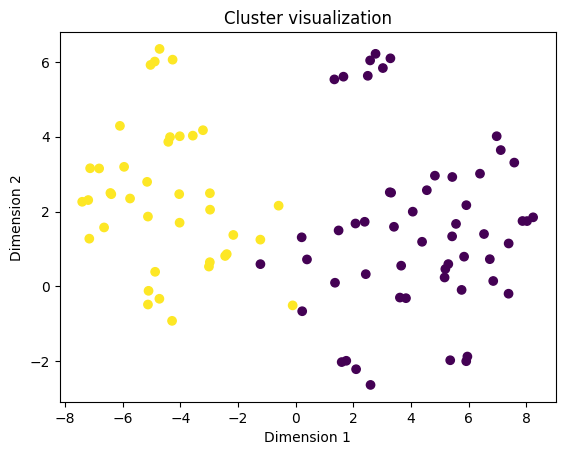

In [79]:
num_clusters = find_optimal_clusters(vectors, max_k=20)
kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(vectors)
plot_clusters(vectors, kmeans)

Get the vectors which are closest to the center of the cluster, then sort them so that they are processed in order.
Lastly, we fetch the document from that index.

In [80]:
def get_key_chunks(vectors, alg, num_clusters, documents):
    closest_indices = []

    for i in range(num_clusters):
        distances = np.linalg.norm(vectors - alg.cluster_centers_[i], axis=1)

        closest_index = np.argmin(distances)
        closest_indices.append(closest_index)

    selected_indices = sorted(closest_indices)
    selected_docs = [documents[doc] for doc in selected_indices]
    return selected_docs

In [81]:
from langchain import PromptTemplate

map_prompt = """
You will be given a piece of a larger text. This piece of text will be enclosed in triple backticks (```).
Your job is to give a summary of this piece of text so that the reader will have a full understanding of what the text is about.
Your response should be at least three paragraphs and fully encompass what was written in the piece of text.

```{text}```
FULL SUMMARY:
"""

map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [82]:
from langchain.chains.summarize import load_summarize_chain

map_chain = load_summarize_chain(llm=llm, chain_type="stuff", prompt=map_prompt_template)

summary_list = []

selected_docs = get_key_chunks(vectors, kmeans, num_clusters, split_docs)

for i, doc in enumerate(selected_docs):
    chunk_summary = map_chain.run([doc])
    summary_list.append(chunk_summary)

    print(f'Summary #{i} - Preview: {chunk_summary[:250]} \n')

Summary #0 - Preview: The given text provides recommendations on choosing a Content Management System (CMS) for Nord University. It highlights four platforms that stand out: Wordpress, Episerver, Umbraco, and Craft. Episerver and Umbraco, being part of the Microsoft famil 

Summary #1 - Preview: The text outlines the terms and conditions regarding the pricing, extension, and responsibilities of the service provider (Leverandøren) and the customer (Kunden) in a contractual agreement. It specifies that the customer is not required to pay any f 



In [83]:
llm4 = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-4-turbo-preview")

In [84]:
from langchain.schema import Document
summaries = "\n".join(summary_list)

summaries = Document(page_content=summaries)

print(f'All your summaries together are {llm.get_num_tokens(summaries.page_content)} tokens')

All your summaries together are 540 tokens


In [85]:
combine_prompt = """
You will now be given a series of summaries from a larger text. The summaries will be enclosed in triple backticks(```).
Your goal is to give a summary of what happened in the greater piece of text.
The reader should be able to grasp what the full text is about from your summary.

```{text}```
SUMMARY:
"""

combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [86]:
reduce_chain = load_summarize_chain(llm=llm4, chain_type="stuff", prompt=combine_prompt_template)

output = reduce_chain.run([summaries])

In [87]:
print(output)

The larger text provides a comprehensive guide on selecting a Content Management System (CMS) for Nord University, evaluating platforms like Wordpress, Episerver, Umbraco, and Craft based on various criteria including cost, SEO, user experience, and their current phases of development. It emphasizes the need for the university's website to quickly convert visitors into users by being visually appealing, user-friendly, and effectively targeting various user groups to relevant content and landing pages. The text also covers technical aspects of CMS setup such as template design, validation, SEO, user experience checks, and the importance of a streamlined website architecture through access control, data management, and content hierarchy. Additionally, it discusses SEO strategies, sustainability practices, and performance metrics vital for the website's success.

Moreover, the text outlines contractual terms between the service provider and the customer, detailing conditions around fees, 